# Part 3: Modeling With Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import datetime 

Feature Engineering Function for Arimax and XGBoost Models 

In [2]:
def feature_engineering(data, internet_data):
    
    # if not isinstance(data.index, datetime.date):
    data['Date'] = pd.to_datetime(data['Date'])
    internet_data['Date'] = pd.to_datetime(internet_data['Date'])

    data = internet_data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    # Set 'Date' column as the index
    data.set_index('Date', inplace=True)


    # Extract components from the date column
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_year'] = data.index.dayofyear
    data['quarter'] = data.index.quarter
    data['season'] = data['month'] % 12 // 3 + 1



    # Trigonometric transformation for 'quarter' feature
    data['quarter_sin'] = np.sin(2 * np.pi * data['quarter'] / 4)
    data['quarter_cos'] = np.cos(2 * np.pi * data['quarter'] / 4)

    # Trigonometric transformation for 'season' feature
    data['season_sin'] = np.sin(2 * np.pi * data['season'] / 4)
    data['season_cos'] = np.cos(2 * np.pi * data['season'] / 4)

    # Calculate the number of days remaining in the year
    data['days_remaining'] = 365 - data['day_of_year']
    # Define a threshold for the number of days considered as "last days"
    last_days_threshold = 10
    # Create a binary indicator for last days of the year
    data['is_last_days'] = (data['days_remaining'] <= last_days_threshold).astype(int)

    data['months_remaining'] = 12 - data['month']
    last_months_threshold = 3
    data['is_last_months'] = (data['months_remaining'] <= last_days_threshold).astype(int)

    # Create a binary indicator for last months of 2016
    is_last_months_of2016 = ((data['year'] == 2016) & (data['months_remaining'] <= last_months_threshold)).astype(int)
    data['is_last_months_of2016'] = is_last_months_of2016

    is_second_half_of2016 = ((data['year'] == 2016) & (data['months_remaining'] <= 7)).astype(int)
    data['is_second_half_of2016'] = is_second_half_of2016



    # derive the trigonometric cycles from the components of date
    data['month_rad'] = 2 * np.pi * (data['month'] - 1) / 12
    data['day_rad'] = 2 * np.pi * (data['day'] - 1) / 31

    # Apply sine and cosine transformations
    data['sin_month'] = np.sin(data['month_rad'])
    data['cos_month'] = np.cos(data['month_rad'])
    data['sin_day'] = np.sin(data['day_rad'])
    data['cos_day'] = np.cos(data['day_rad'])


    # Calculate numerical representation of 'Date'
    data['Date_numeric'] = (data.index - data.index.min()).days

    # Function to apply cyclical encoding
    def apply_cyclical_encoding(data, column):
        data[column + '_sin'] = np.sin(2 * np.pi * data[column] / data[column].max())
        data[column + '_cos'] = np.cos(2 * np.pi * data[column] / data[column].max())
        return data

    data = apply_cyclical_encoding(data, 'Date_numeric')


    # add new features
    data['is_saturday'] = (data.index.weekday == 5).astype(int)      
    data['is_monday'] = (data.index.weekday == 0).astype(int)         
    data['is_tuesday'] = (data.index.weekday == 1).astype(int)
    data['is_thursday'] = (data.index.weekday == 3).astype(int)
    data['is_sunday'] = (data.index.weekday == 6).astype(int)         
    data['is_december'] = (data['month'] == 12).astype(int)           
    data['is_july'] = (data['month'] == 7).astype(int)  
    data['open_price_lag1'] = data['Open'].shift(1)                   # from the EDA we know that lag1 is important
    data['open_price_lag9'] = data['Open'].shift(9)                   # from the EDA we know that lag9 is important
    data['Close'] = data['Close'].shift(2)
    data['High'] = data['High'].shift(1)
    data['Low'] = data['Low'].shift(1)
    data['Volume'] = data['Volume'].shift(1)
    data['Adj Close'] = data['Adj Close'].shift(2)
    

    interval = len(data) - 60
    #Apply rolling window statistics to 'Open' column
    data['rolling_mean'] = data[:interval]['Open'].rolling(window=7,closed = 'left').mean() 
    data['rolling_std'] = data[:interval]['Open'].rolling(window=7, closed = 'left').std()
    data['rolling_50'] = data[:interval]['Open'].rolling(window=50,closed = 'left').mean() 


    # Function to calculate MACD
    def calculate_macd(data):
        
        data['ema12'] = data['Adj Close'].ewm(span=12).mean()
        data['ema26'] = data['Adj Close'].ewm(span=26).mean()

        data['macd'] = data['ema12'] - data['ema26']

        data['macd_signal'] = data['macd'].ewm(span=9).mean()
        data['macd_hist'] = data['macd'] - data['macd_signal']

        return data

    data = calculate_macd(data)
    
    
    # Function to calculate RSI
    def calculate_rsi(data):
        change = data["Open"].diff()
        change.dropna(inplace=True)

        change_up = change.copy()
        change_down = change.copy()

        # 
        change_up[change_up<0] = 0
        change_down[change_down>0] = 0

        # Verify that we did not make any mistakes
        change.equals(change_up+change_down)

        # Calculate the rolling average of average up and average down
        avg_up = change_up.rolling(14).mean()
        avg_down = change_down.rolling(14).mean().abs()

        rsi = 100 * avg_up / (avg_up + avg_down)

        # Take a look at the 20 oldest datapoints
        rsi.head(20)

        data['RSI'] = rsi

        return data
    
    data = calculate_rsi(data)

    data = data.drop(columns=['Adj Close'])

    # Mean Imputation
    data.fillna(data.mean(),inplace=True)
    data.isnull().sum()

    feature_columns = ['High', 'Low', 'Close', 'Volume',
                   'year', 
                   'month',
                   'day_of_year', 
                   'quarter',
                   'season',
                   'days_remaining',
                   'is_last_days',
                   'months_remaining',
                   'is_last_months',
                   'is_last_months_of2016',
                   'is_second_half_of2016',
                   'month_rad',
                   'sin_month',
                   'Date_numeric',
                   'Date_numeric_sin',
                   'Date_numeric_cos',
                   'is_december',
                   'open_price_lag1',
                   'rolling_mean',
                   'rolling_std',
                   'rolling_50',
                   'ema12',
                   'ema26',
                   'macd',
                   'RSI'
                   ]


    target_column = ['Open']

    return data, feature_columns, target_column

Feature Engineering Function for Neural Network

In [3]:
def neural_engineering(data, internet_data):
    
    # if not isinstance(data.index, datetime.date):
    data['Date'] = pd.to_datetime(data['Date'])
    internet_data['Date'] = pd.to_datetime(internet_data['Date'])

    data = internet_data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    # Set 'Date' column as the index
    data.set_index('Date', inplace=True)


    # Extract components from the date column
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_year'] = data.index.dayofyear
    data['quarter'] = data.index.quarter
    data['season'] = data['month'] % 12 // 3 + 1

    # Trigonometric transformation for 'quarter' feature
    data['quarter_sin'] = np.sin(2 * np.pi * data['quarter'] / 4)
    data['quarter_cos'] = np.cos(2 * np.pi * data['quarter'] / 4)

    # Trigonometric transformation for 'season' feature
    data['season_sin'] = np.sin(2 * np.pi * data['season'] / 4)
    data['season_cos'] = np.cos(2 * np.pi * data['season'] / 4)


    # Calculate the number of days remaining in the year
    data['days_remaining'] = 365 - data['day_of_year']
    # Define a threshold for the number of days considered as "last days"
    last_days_threshold = 10
    # Create a binary indicator for last days of the year
    data['is_last_days'] = (data['days_remaining'] <= last_days_threshold).astype(int)

    data['months_remaining'] = 12 - data['month']
    last_months_threshold = 3
    data['is_last_months'] = (data['months_remaining'] <= last_days_threshold).astype(int)

    # Create a binary indicator for last months of 2016
    is_last_months_of2016 = ((data['year'] == 2016) & (data['months_remaining'] <= last_months_threshold)).astype(int)
    data['is_last_months_of2016'] = is_last_months_of2016

    is_second_half_of2016 = ((data['year'] == 2016) & (data['months_remaining'] <= 7)).astype(int)
    data['is_second_half_of2016'] = is_second_half_of2016



    # derive the trigonometric cycles from the components of date
    data['month_rad'] = 2 * np.pi * (data['month'] - 1) / 12
    data['day_rad'] = 2 * np.pi * (data['day'] - 1) / 31

    # Apply sine and cosine transformations
    data['sin_month'] = np.sin(data['month_rad'])
    data['cos_month'] = np.cos(data['month_rad'])
    data['sin_day'] = np.sin(data['day_rad'])
    data['cos_day'] = np.cos(data['day_rad'])


    # Calculate numerical representation of 'Date'
    data['Date_numeric'] = (data.index - data.index.min()).days

    # Function to apply cyclical encoding
    def apply_cyclical_encoding(data, column):
        data[column + '_sin'] = np.sin(2 * np.pi * data[column] / data[column].max())
        data[column + '_cos'] = np.cos(2 * np.pi * data[column] / data[column].max())
        return data

    data = apply_cyclical_encoding(data, 'Date_numeric')


    # add new features
    data['is_saturday'] = (data.index.weekday == 5).astype(int)       # price is high
    data['is_monday'] = (data.index.weekday == 0).astype(int)         # price is low
    data['is_tuesday'] = (data.index.weekday == 1).astype(int)
    data['is_thursday'] = (data.index.weekday == 3).astype(int)
    data['is_sunday'] = (data.index.weekday == 6).astype(int)         # price is low
    data['is_december'] = (data['month'] == 12).astype(int)           # price is high
    data['is_july'] = (data['month'] == 7).astype(int)  
    #data['is_2017'] = (data['year'] == 2017).astype(int)              # price is high
    data['open_price_lag1'] = data['Open'].shift(1)                   # from the EDA we know that lag1 is important
    data['open_price_lag9'] = data['Open'].shift(9)                   # from the EDA we know that lag9 is important
    data['Close'] = data['Close'].shift(2)
    data['High'] = data['High'].shift(2)
    data['Low'] = data['Low'].shift(2)
    data['Volume'] = data['Volume'].shift(2)
    


    interval = len(data) - 90
    #Apply rolling window statistics to 'Open' column
    data['rolling_mean'] = data[:interval]['Open'].rolling(window=7,closed = 'left').mean() 
    data['rolling_std'] = data[:interval]['Open'].rolling(window=7, closed = 'left').std()
    data['rolling_50'] = data[:interval]['Open'].rolling(window=50,closed = 'left').mean() 
    
# Function to calculate MACD
    def calculate_macd(data):
        
        data['ema12'] = data['Adj Close'].ewm(span=12).mean()
        data['ema26'] = data['Adj Close'].ewm(span=26).mean()

        data['macd'] = data['ema12'] - data['ema26']

        data['macd_signal'] = data['macd'].ewm(span=9).mean()
        data['macd_hist'] = data['macd'] - data['macd_signal']

        return data

    data = calculate_macd(data)
    
    
    # Function to calculate RSI
    def calculate_rsi(data):
        change = data["Open"].diff()
        change.dropna(inplace=True)

        change_up = change.copy()
        change_down = change.copy()

        # 
        change_up[change_up<0] = 0
        change_down[change_down>0] = 0

        # Verify that we did not make any mistakes
        change.equals(change_up+change_down)

        # Calculate the rolling average of average up and average down
        avg_up = change_up.rolling(14).mean()
        avg_down = change_down.rolling(14).mean().abs()

        rsi = 100 * avg_up / (avg_up + avg_down)

        # Take a look at the 20 oldest datapoints
        rsi.head(20)

        data['RSI'] = rsi

        return data
    
    data = calculate_rsi(data)

    data = data.drop(columns=['Adj Close'])

    # Mean Imputation
    data.fillna(data.mean(),inplace=True)
    data.isnull().sum()

    feature_columns = ['High', 'Low', 'Close', 'Volume',
                   'year', 
                   'month',
                   'day_of_year', 
                   'quarter',
                   'season',
                   'days_remaining',
                   'is_last_days',
                   'months_remaining',
                   'is_last_months',
                   'is_last_months_of2016',
                   'is_second_half_of2016',
                   'month_rad',
                   'sin_month',
                   'Date_numeric',
                   'Date_numeric_sin',
                   'Date_numeric_cos',
                   'is_december',
                   'open_price_lag1',
                   'rolling_mean',
                   'rolling_std',
                   'rolling_50',
                   'ema12',
                   'ema26',
                   'macd',
                   'RSI'
                   ]

    target_column = ['Open']

    return data, feature_columns, target_column

In [4]:
#function for printing correlation heatmap
def corr_plot(data):
    correlation = data.corr(method='pearson', numeric_only=True)
    plt.figure(figsize=(15, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')

    plt.show()

# XGBoost Prediction with Feature Engineering

In [5]:
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score


In [6]:
general_path = globals()['_dh'][0]    #The path to the main folder
# read the dataset
data = pd.read_csv(os.path.join(general_path,"Btc_small.csv"))
internet_data = pd.read_csv(os.path.join(general_path,"BTC-USD.csv"))
internet_data = internet_data[:len(data)]


data, feature_columns, target_column = feature_engineering(data, internet_data)

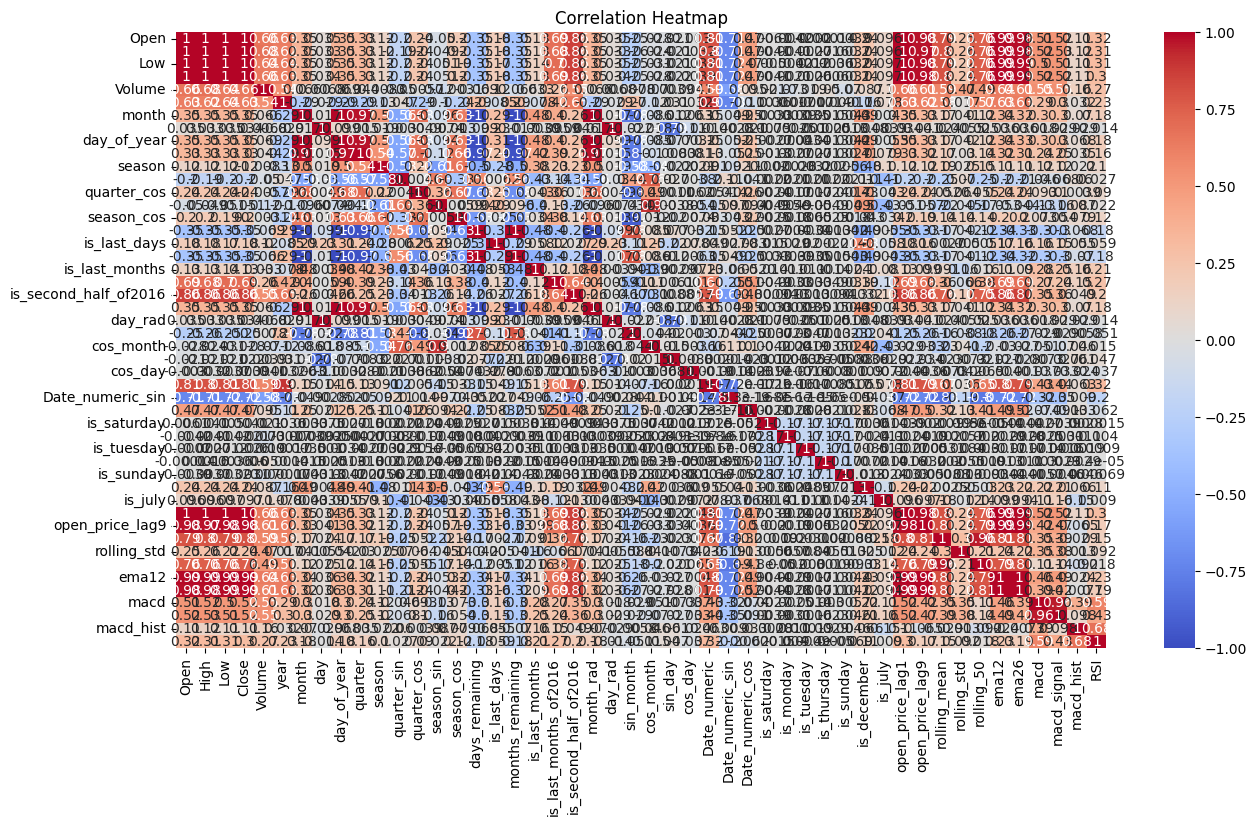

In [7]:
corr_plot(data)

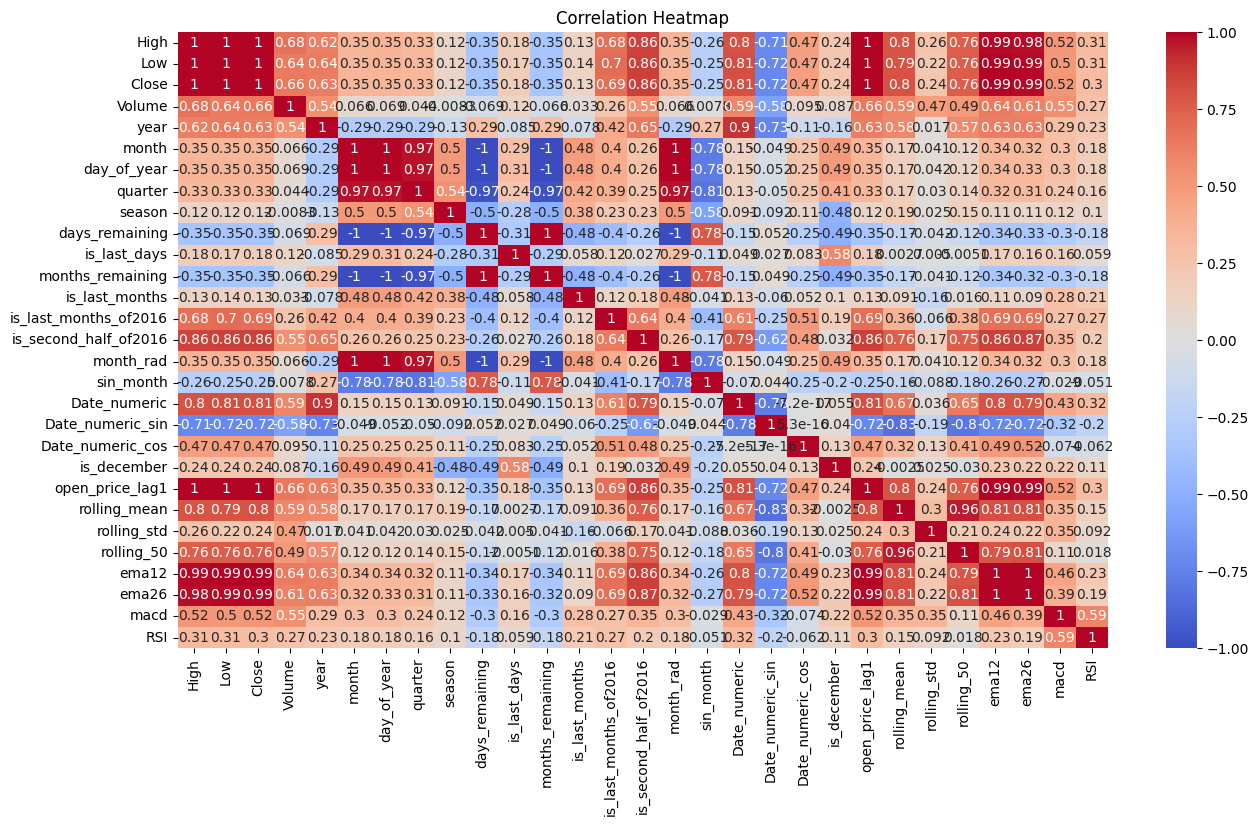

In [8]:
corr_plot(data[feature_columns])

In [9]:
# Split the data into train, validation, and test sets
train_size = len(data) - 120
val_size = len(data) - 60
train = data[:train_size + 1]
valid = data[train_size:val_size + 1]
test = data[val_size:]

# Extract the features and target variable for each set
X_train = train[feature_columns]
Y_train = train[target_column]

X_val = valid[feature_columns]
y_val = valid[target_column]

x_test = test[feature_columns]
y_test = test[target_column]

In [10]:
xg_boost = XGBRegressor(reg_lambda= 0.5, reg_alpha= 1, n_estimators= 500, learning_rate= 0.3,
                        booster= 'gblinear', random_state= 42)

xg_boost.fit(X_train, Y_train)
pred_train_xg = xg_boost.predict(X_train)
pred_valid_xg = xg_boost.predict(X_val)
pred_xg = xg_boost.predict(x_test)

rmse_xg = mean_squared_error(y_test, pred_xg, squared=False)
rmse_train_xg = mean_squared_error(Y_train, pred_train_xg, squared=False)
rmse_val_xg = mean_squared_error(y_val, pred_valid_xg, squared=False)
r2_score_xg = r2_score(y_test, pred_xg)
r2_score_train_xg = r2_score(Y_train, pred_train_xg)
r2_score_valid_xg = r2_score(y_val, pred_valid_xg)

In [11]:

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test["Open"], name="Actual_test"))
fig.add_trace(go.Scatter(x=y_test.index, y=pred_xg, name="XGBoost Test"))
fig.add_trace(go.Scatter(x=y_val.index, y=y_val["Open"], name="Actual_valid", line= dict(color= 'black')))
fig.add_trace(go.Scatter(x=y_val.index, y=pred_valid_xg, name="XGBoost valid", line= dict(color= 'magenta')))
fig.add_trace(go.Scatter(x=Y_train.index, y=Y_train["Open"], name="Actual_train"))
fig.add_trace(go.Scatter(x=Y_train.index, y=pred_train_xg, name="XGBoost train", line= dict(color= 'green')))


fig.update_layout(height=750)
fig.show()

naive_train = mean_squared_error(Y_train,Y_train.shift(1).bfill(), squared=False)
naive_valid = mean_squared_error(y_val,y_val.shift(1).bfill(), squared=False)
naive_test = mean_squared_error(y_test,y_test.shift(1).bfill(), squared=False)
print("Naive Train:", naive_train)
print("Naive Valid:", naive_valid)
print("Naive Test:", naive_test)
#print("***********************************************************************************")
print("-----------------------------------------------------------------------------------")
print("Root Mean Squared Error (Train - XGBoost):", rmse_train_xg)
print("Root Mean Squared Error (Valid - XGBoost):", rmse_val_xg)
print("Root Mean Squared Error (Test - XGBoost):", rmse_xg)
print("-----------------------------------------------------------------------------------")
print("R2 Score (Train - XGBoost):", r2_score_train_xg)
print("R2 Score (Valid - XGBoost):", r2_score_valid_xg)
print("R2 Score (Test - XGBoost):", r2_score_xg)

Naive Train: 12.489057713659749
Naive Valid: 8.730659936852595
Naive Test: 16.0898826409532
-----------------------------------------------------------------------------------
Root Mean Squared Error (Train - XGBoost): 8.766465380779596
Root Mean Squared Error (Valid - XGBoost): 5.57737391987574
Root Mean Squared Error (Test - XGBoost): 10.751990946077884
-----------------------------------------------------------------------------------
R2 Score (Train - XGBoost): 0.9953721844601466
R2 Score (Valid - XGBoost): 0.9685389131591097
R2 Score (Test - XGBoost): 0.9771208757891263


# Arima and Arimax Predictions

Arima Model

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

In [13]:
general_path = globals()['_dh'][0]    #The path to the main folder
# read the dataset
data = pd.read_csv(os.path.join(general_path,"Btc_small.csv"))
internet_data = pd.read_csv(os.path.join(general_path, "BTC-USD.csv"))
internet_data = internet_data[:len(data)]
train = internet_data.copy()


In [14]:
data = train['Open']
Date1 = train['Date']
train1 = train[['Date', 'Open']]
# Setting the Date as Index
train1['Date'] = pd.to_datetime(train1['Date'])
train2 = train1.set_index('Date')
train2.sort_index(inplace=True)

In [15]:
# Function to test stationarity of time series
def test_stationarity(x):
    # Determing rolling statistics
    rolmean = x.rolling(window=22, center=False).mean()
    rolstd = x.rolling(window=12, center=False).std()

   #  # Plot rolling statistics:
   #  orig = plt.plot(x, color='blue', label='Original')
   #  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
   #  std = plt.plot(rolstd, color='black', label='Rolling Std')
   #  plt.legend(loc='best')
   #  plt.title('Rolling Mean & Standard Deviation')
   #  plt.show(block=False)

    # Perform Dickey Fuller test
    result = sm.tsa.adfuller(x)
    print('ADF Stastistic: %f' % result[0])
    print('p-value: %f' % result[1])
    pvalue = result[1]
    for key, value in result[4].items():
        if result[0] > value:
            print("The graph is non-stationary")
            break
        else:
            print("The graph is stationary")
            break
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


In [16]:
# Test stationarity of the 'Open' time series
ts = train2['Open']
test_stationarity(ts)


ADF Stastistic: 1.644300
p-value: 0.997985
The graph is non-stationary
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [17]:
# Convert to log scale
ts_log = np.log(ts)

# Test stationarity of the log-transformed time series
test_stationarity(ts_log)


ADF Stastistic: 0.177097
p-value: 0.970947
The graph is non-stationary
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [18]:
# Differencing to make the time series stationary
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

# Test stationarity of the differenced time series
test_stationarity(ts_log_diff)


ADF Stastistic: -10.392164
p-value: 0.000000
The graph is stationary
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [19]:
# Train-test split
size = int(len(ts_log) - 60)
train_arima, test_arima = ts_log[0:size], ts_log[size:]

# ARIMA model
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

In [20]:
print('Printing Predicted vs Expected Values...\n')

# Fit ARIMA model and make predictions on the test set
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    
    output = model_fit.forecast(steps=1)
    
    pred_value = np.exp(output[0])  # Extracting the forecasted value from the output array
    original_value = np.exp(test_arima[t])
    
    history.append(test_arima[t])  # Update the history with the original value (not the log transformed)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f, expected = %f, error = %f%%' % (pred_value, original_value, error))
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))

# Calculate mean error on the test set   
mean_error = sum(error_list) / float(len(error_list))
print('\nMean Error in Predicting Test Case Articles: %f%%' % mean_error)

# naive_test = mean_squared_error(originals, originals.shift(1).bfill(), squared=False)
# print("Naive Test:", naive_test)
# print("***********************************************************************************")
rmse_arima = mean_squared_error(originals, predictions, squared=False)
print('Naive Test:', naive_test)
print("Root Mean Squared Error (ARIMA):", rmse_arima)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_arima.index[1:], y=originals, name="Actual_test"))
fig.add_trace(go.Scatter(x=test_arima.index[1:], y=predictions, name="Arimax Test Pred"))

fig.update_layout(height=750)
fig.show()


Printing Predicted vs Expected Values...

predicted = 702.511400, expected = 730.065979, error = 3.774259%


predicted = 731.153254, expected = 742.346008, error = 1.507754%
predicted = 739.545691, expected = 689.124023, error = 7.316777%
predicted = 686.236194, expected = 703.525024, error = 2.457458%
predicted = 709.773552, expected = 703.812012, error = 0.847036%
predicted = 702.221407, expected = 710.736023, error = 1.198000%
predicted = 710.905151, expected = 703.088989, error = 1.111689%
predicted = 702.116363, expected = 709.825012, error = 1.085993%
predicted = 710.860122, expected = 722.843994, error = 1.657878%
predicted = 722.465919, expected = 715.554993, error = 0.965813%
predicted = 713.920945, expected = 716.752014, error = 0.394986%
predicted = 717.584020, expected = 705.195984, error = 1.756680%
predicted = 704.740608, expected = 701.997009, error = 0.390828%
predicted = 703.156835, expected = 705.794006, error = 0.373646%
predicted = 706.254595, expected = 711.166992, error = 0.690752%
predicted = 710.900504, expected = 744.875977, error = 4.561226%
predicted = 745.259503, e

Arimax Modeling

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")


In [22]:
general_path = globals()['_dh'][0]    #The path to the main folder
# read the dataset
data = pd.read_csv(os.path.join(general_path,"Btc_small.csv"))
internet_data = pd.read_csv(os.path.join(general_path, "BTC-USD.csv"))
internet_data = internet_data[:len(data)]
train = internet_data.copy()

In [23]:
data = train['Open']
Date1 = train['Date']
train1 = train[['Date', 'Open']]
# Setting the Date as Index
train1['Date'] = pd.to_datetime(train1['Date'])
train2 = train1.set_index('Date')
train2.sort_index(inplace=True)


In [24]:
# Test stationarity of the 'Open' time series
ts = train2['Open']
test_stationarity(ts)

# Convert to log scale
ts_log = np.log(ts)

# Test stationarity of the log-transformed time series
test_stationarity(ts_log)

# Differencing to make the time series stationary
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

# Test stationarity of the differenced time series
test_stationarity(ts_log_diff)

ADF Stastistic: 1.644300
p-value: 0.997985
The graph is non-stationary
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Stastistic: 0.177097
p-value: 0.970947
The graph is non-stationary
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
ADF Stastistic: -10.392164
p-value: 0.000000
The graph is stationary
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [25]:
# Train-test split
size = int(len(ts_log) - 60)
train_arima, test_arima = ts_log[0:size], ts_log[size:]


# ARIMAX model

train, feature_columns, target_column = feature_engineering(train, internet_data)

exog_train = train[feature_columns]  # Use some features as exogenous variables
exog_train = exog_train.to_numpy()

history = train_arima.tolist()
predictions_arimax = list()
originals = list()
error_list = list()

In [26]:
print('Printing Predicted vs Expected Values (ARIMAX)...\n')

# Fit ARIMAX model and make predictions on the test set
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 0), exog=exog_train[:len(history)])
    model_fit = model.fit()
    
    # Forecast using the last value from the exogenous variables
    exog_forecast = exog_train[len(history):len(history) + 1]
    
    output = model_fit.forecast(steps=1, exog=exog_forecast)
    
    pred_value = np.exp(output[0])  # Extracting the forecasted value from the output array
    original_value = np.exp(test_arima[t])
    
    history.append(test_arima[t])  # Update the history with the original value (not the log transformed)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f, expected = %f, error = %f%%' % (pred_value, original_value, error))
    
    predictions_arimax.append(float(pred_value))
    originals.append(float(original_value))

# Calculate mean error on the test set   
mean_error = sum(error_list) / float(len(error_list))
print('\nMean Error in Predicting Test Case Articles (ARIMAX): %f%%' % mean_error)
rmse_arimax = mean_squared_error(originals, predictions_arimax, squared=False)
print('Naive Test:', naive_test)
print("Root Mean Squared Error (ARIMAX - Test):", rmse_arimax)


# Plotting the predictions
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_arima.index[1:], y=originals, name="Actual_test"))
fig.add_trace(go.Scatter(x=test_arima.index[1:], y=predictions_arimax, name="Arimax Test Pred"))

fig.update_layout(height=750)
fig.show()

Printing Predicted vs Expected Values (ARIMAX)...

predicted = 607.425435, expected = 730.065979, error = 16.798556%
predicted = 730.262724, expected = 742.346008, error = 1.627716%
predicted = 665.073196, expected = 689.124023, error = 3.490058%
predicted = 708.666131, expected = 703.525024, error = 0.730764%
predicted = 698.536377, expected = 703.812012, error = 0.749580%
predicted = 710.308440, expected = 710.736023, error = 0.060161%
predicted = 699.319287, expected = 703.088989, error = 0.536163%
predicted = 713.917617, expected = 709.825012, error = 0.576565%
predicted = 736.045069, expected = 722.843994, error = 1.826269%
predicted = 693.796928, expected = 715.554993, error = 3.040726%
predicted = 716.027814, expected = 716.752014, error = 0.101039%
predicted = 693.500265, expected = 705.195984, error = 1.658506%
predicted = 684.289198, expected = 701.997009, error = 2.522491%
predicted = 716.018796, expected = 705.794006, error = 1.448693%
predicted = 712.846488, expected = 711

# Prediction With Neural Network

In [27]:
import torch
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd

import numpy as np
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.graph_objects as go

In [28]:
general_path = globals()['_dh'][0]    #The path to the main folder
# read the dataset
data = pd.read_csv(os.path.join(general_path,"Btc_small.csv"))
internet_data = pd.read_csv(os.path.join(general_path, "BTC-USD.csv"))
internet_data = internet_data[:len(data)]

In [29]:
# Perform feature engineering on the dataset
data, feature_columns, target_column = neural_engineering(data, internet_data)

In [30]:
# Split the data into train, validation, and test sets
train_size = len(data) - 120
val_size = len(data) - 60
train = data[:train_size + 1]
valid = data[train_size:val_size + 1]
test = data[val_size:]

# Extract the features and target variable for each set
X_train = train[feature_columns]
Y_train = train[target_column]

X_val = valid[feature_columns]
y_val = valid[target_column]

x_test = test[feature_columns]
y_test = test[target_column]

In [31]:
# Normalize the data using StandardScaler
mScalar = StandardScaler()
mScalar.fit(X_train)
X_train_scaled = mScalar.fit_transform(X_train)
X_val_scaled = mScalar.transform(X_val)
X_test_scaled = mScalar.transform(x_test)

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
X_val_tensor = torch.from_numpy(X_val_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()

y_train_tensor = torch.from_numpy(Y_train.values).float() / 1000
y_val_tensor = torch.from_numpy(y_val.values).float() / 1000
y_test_tensor = torch.from_numpy(y_test.values).float() / 1000

In [32]:
# Define the MLP model class
class mMLP(torch.nn.Module):
    def __init__(self, input_dim, out_dim):
        super(mMLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 32)
        self.layer2 = torch.nn.Linear(32, 32)
        self.layer3 = torch.nn.Linear(32, 32)
        self.layer4 = torch.nn.Linear(32, out_dim)

        self.act_func = torch.nn.LeakyReLU()

    def forward(self, x_):
        out1 = self.layer1(x_)
        out1 = self.act_func(out1)

        out1 = self.layer2(out1)
        out1 = self.act_func(out1)

        out1 = self.layer3(out1)
        out1 = self.act_func(out1)

        out1 = self.layer4(out1)
        return out1

In [33]:
# Seed for reproducibility
torch.manual_seed(42)

# Create the MLP model
mModel = mMLP(input_dim=X_train_tensor.shape[1], out_dim=1)

# Set the maximum number of epochs for training
MAX_EPOCH = 10000

# Create the optimizer and loss function
mOptimizer = torch.optim.Adam(params=mModel.parameters(), lr=5.7e-2)
mLoss = torch.nn.MSELoss()

# Lists to store training and validation losses during training
val_losses_list, train_losses_list = [], []

# Variables to keep track of the best model and the best validation loss
best_model = None
min_val_loss = np.inf


Epoch    0: Train Loss: 0.11098143 Val Loss: 7.96472597, Min Val Loss is at Epoch:    0, : 7.96472597
Epoch  100: Train Loss: 0.00028533 Val Loss: 0.00114989, Min Val Loss is at Epoch:   95, : 0.00059369
Epoch  200: Train Loss: 0.00017852 Val Loss: 0.02527216, Min Val Loss is at Epoch:   95, : 0.00059369
Epoch  300: Train Loss: 0.00014606 Val Loss: 0.01644947, Min Val Loss is at Epoch:   95, : 0.00059369
Epoch  400: Train Loss: 0.00010998 Val Loss: 0.00144841, Min Val Loss is at Epoch:   95, : 0.00059369
Epoch  500: Train Loss: 0.00010309 Val Loss: 0.00055137, Min Val Loss is at Epoch:  468, : 0.00032292
Epoch  600: Train Loss: 0.00008875 Val Loss: 0.00043282, Min Val Loss is at Epoch:  570, : 0.00027380
Epoch  700: Train Loss: 0.00008418 Val Loss: 0.00048857, Min Val Loss is at Epoch:  630, : 0.00019839
Epoch  800: Train Loss: 0.00008083 Val Loss: 0.00058326, Min Val Loss is at Epoch:  737, : 0.00015059
Epoch  900: Train Loss: 0.00008418 Val Loss: 0.00048672, Min Val Loss is at Epoch:

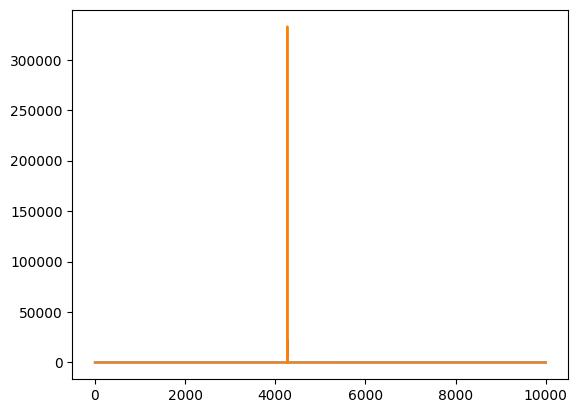

Naive Train: 12.489057713659749
Naive Valid: 8.730659936852595
Naive Test: 16.0898826409532
---------------------------------
Train RMSE: 8.2747
Valid RMSE: 8.1494
Test RMSE: 25.1658
---------------------------------
Train R2 Score: 0.9959
Valid R2 Score: 0.9328
Test R2 Score: 0.8747


In [34]:
# Training loop
for epoch_indx in range(MAX_EPOCH):
    mModel.train()
    train_preds = mModel.forward(X_train_tensor)

    # Compute the training loss and store it
    loss = mLoss(train_preds, y_train_tensor)
    train_losses_list.append(loss.item())
    
    # Print the training loss every 100 epochs
    if epoch_indx % 100 == 0:
        print(f"Epoch {epoch_indx:4d}: Train Loss: {loss.item():.8f}", end=" ")

    # Perform backpropagation and update the model's parameters
    mOptimizer.zero_grad()
    loss.backward()
    mOptimizer.step()

    # Validation
    with torch.no_grad():
        mModel.eval()
        val_preds = mModel.forward(X_val_tensor)
        val_loss = mLoss(val_preds, y_val_tensor)
        val_losses_list.append(val_loss.item())

        # Print the validation loss and update the best model
        if epoch_indx % 100 == 0:
            min_val_loss_index = np.argmin(np.asarray(val_losses_list))
            min_val_loss = np.min(np.asarray(val_losses_list))
            print(f"Val Loss: {val_loss.item():.8f}, Min Val Loss is at Epoch: {min_val_loss_index:4d}, : {min_val_loss:.8f}")    
        
        if min_val_loss > val_loss.item():
            min_val_loss = val_loss.item()
            best_model = copy.deepcopy(mModel)

# Plot the training and validation losses
plt.plot(train_losses_list)
plt.plot(val_losses_list)
plt.show()

# Perform predictions using the best model on train, validation, and test sets
with torch.no_grad():
    train_preds = best_model.forward(X_train_tensor).numpy() * 1000
    train_preds = pd.DataFrame(train_preds, index=X_train.index)
    
    val_preds = best_model.forward(X_val_tensor).numpy() * 1000
    val_preds = pd.DataFrame(val_preds, index=X_val.index)
    
    test_preds = best_model.forward(X_test_tensor).numpy() * 1000
    test_preds = pd.DataFrame(test_preds, index=x_test.index)

# Calculate RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(Y_train, train_preds))
valid_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

# Calculate R2 score for train and test sets
train_r2 = r2_score(Y_train, train_preds)
valid_r2 = r2_score(y_val, val_preds)
test_r2 = r2_score(y_test, test_preds)

# Create the plotly figure for visualization
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_preds.index, y=train_preds[0],  name="Train Predictions", line=dict(color='dodgerblue'))
)
fig.add_trace(
    go.Scatter(x=val_preds.index, y=val_preds[0],  name="Validation Predictions", line=dict(color='magenta'))
)
fig.add_trace(
    go.Scatter(x=test_preds.index, y=test_preds[0],  name="Test Predictions", line=dict(color='orange'))
)
fig.add_trace(
    go.Scatter(x=pd.DataFrame(Y_train).index, y=pd.DataFrame(Y_train)["Open"],  name="Train Target", line=dict(color='brown'))
)
fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_val).index, y=pd.DataFrame(y_val)["Open"],  name="Validation Target", line=dict(color='black'))
)
fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_test).index, y=pd.DataFrame(y_test)["Open"],  name="Test Target", line=dict(color='green'))
)
fig.update_layout(height=600)
fig.show()


print("Naive Train:", naive_train)
print("Naive Valid:", naive_valid)
print("Naive Test:", naive_test)
print("---------------------------------")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Valid RMSE: {valid_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print("---------------------------------")
print(f"Train R2 Score: {train_r2:.4f}")
print(f"Valid R2 Score: {valid_r2:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")

# Ensembling Models

Ensemble Arima and Neural Network Models

In [35]:
# Convert the ARIMA predictions to a pandas DataFrame with the same index as test_preds
test_preds_arima = pd.DataFrame(predictions, index=test_preds.index, columns=[0])

# Calculate the ensemble predictions using the average
ensemble_predictions = (test_preds + test_preds_arima) / 2

In [36]:
# Calculate RMSE for the ensemble predictions
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))

# Calculate R2 score for the ensemble predictions
ensemble_r2 = r2_score(y_test, ensemble_predictions)

# Print the results
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble R2 Score: {ensemble_r2:.4f}")

Ensemble RMSE: 14.4767
Ensemble R2 Score: 0.9585


In [37]:


import plotly.graph_objects as go

# Create a DataFrame for the ensemble predictions
ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=y_test.index, columns=[0])

# Create the Plotly figure
fig = go.Figure()

# Add traces for original target values and ensemble predictions
fig.add_trace(go.Scatter(x=y_test.index, y=y_test["Open"], name="Test Target"))
fig.add_trace(go.Scatter(x=ensemble_predictions_df.index, y=ensemble_predictions_df[0], name="Ensemble Predictions"))

# Update layout and show the figure
fig.update_layout(height=600, title="Ensemble Predictions(Arima - Neural) vs. Test Target")
fig.show()

Ensemble XGBoost and Arimax Models

In [38]:
test_preds_xg = pd.DataFrame(pred_xg, index=test_preds.index, columns=[0])
test_preds_arimax = pd.DataFrame(predictions_arimax, index=test_preds.index, columns=[0])

# Calculate the ensemble predictions using the average
ensemble_predictions = (test_preds_arimax + test_preds_xg) / 2

In [39]:
# Calculate RMSE for the ensemble predictions
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))

# Calculate R2 score for the ensemble predictions
ensemble_r2 = r2_score(y_test, ensemble_predictions)

# Print the results
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble R2 Score: {ensemble_r2:.4f}")

Ensemble RMSE: 11.2950
Ensemble R2 Score: 0.9748


In [40]:
import plotly.graph_objects as go

# Create a DataFrame for the ensemble predictions
ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=y_test.index, columns=[0])

# Create the Plotly figure
fig = go.Figure()

# Add traces for original target values and ensemble predictions
fig.add_trace(go.Scatter(x=y_test.index, y=y_test["Open"], name="Test Target"))
fig.add_trace(go.Scatter(x=ensemble_predictions_df.index, y=ensemble_predictions_df[0], name="Ensemble Predictions"))

# Update layout and show the figure
fig.update_layout(height=600, title="Ensemble Predictions(Arimax - XGBoost) vs. Test Target")
fig.show()

Ensemble Arimax and Arima Models

In [41]:
# Calculate the ensemble predictions using the average
ensemble_predictions = (test_preds_arimax + test_preds_arima) / 2

In [42]:
# Calculate RMSE for the ensemble predictions
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))

# Calculate R2 score for the ensemble predictions
ensemble_r2 = r2_score(y_test, ensemble_predictions)

# Print the results
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble R2 Score: {ensemble_r2:.4f}")

Ensemble RMSE: 12.2706
Ensemble R2 Score: 0.9702


In [43]:
import plotly.graph_objects as go

# Create a DataFrame for the ensemble predictions
ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=y_test.index, columns=[0])

# Create the Plotly figure
fig = go.Figure()

# Add traces for original target values and ensemble predictions
fig.add_trace(go.Scatter(x=y_test.index, y=y_test["Open"], name="Test Target"))
fig.add_trace(go.Scatter(x=ensemble_predictions_df.index, y=ensemble_predictions_df[0], name="Ensemble Predictions"))

# Update layout and show the figure
fig.update_layout(height=600, title="Ensemble Predictions(Arimax - Arima) vs. Test Target")
fig.show()

Ensemble Arimax and Neural Network Models

In [44]:
# Calculate the ensemble predictions using the average
ensemble_predictions = (test_preds_arimax + test_preds) / 2

In [45]:
# Calculate RMSE for the ensemble predictions
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))

# Calculate R2 score for the ensemble predictions
ensemble_r2 = r2_score(y_test, ensemble_predictions)

# Print the results
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble R2 Score: {ensemble_r2:.4f}")

Ensemble RMSE: 16.9726
Ensemble R2 Score: 0.9430


In [46]:
import plotly.graph_objects as go

# Create a DataFrame for the ensemble predictions
ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=y_test.index, columns=[0])

# Create the Plotly figure
fig = go.Figure()

# Add traces for original target values and ensemble predictions
fig.add_trace(go.Scatter(x=y_test.index, y=y_test["Open"], name="Test Target"))
fig.add_trace(go.Scatter(x=ensemble_predictions_df.index, y=ensemble_predictions_df[0], name="Ensemble Predictions"))

# Update layout and show the figure
fig.update_layout(height=600, title="Ensemble Predictions(Arimax - Neural) vs. Test Target")
fig.show()

Ensemble Arimax, Neural Network and XGBoost

In [47]:
# Calculate the ensemble predictions using the average
ensemble_predictions = (test_preds_arimax + test_preds + test_preds_xg) / 3

In [48]:
# Calculate RMSE for the ensemble predictions
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))

# Calculate R2 score for the ensemble predictions
ensemble_r2 = r2_score(y_test, ensemble_predictions)

# Print the results
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble R2 Score: {ensemble_r2:.4f}")

Ensemble RMSE: 11.2802
Ensemble R2 Score: 0.9748


In [49]:
import plotly.graph_objects as go

# Create a DataFrame for the ensemble predictions
ensemble_predictions_df = pd.DataFrame(ensemble_predictions, index=y_test.index, columns=[0])

# Create the Plotly figure
fig = go.Figure()

# Add traces for original target values and ensemble predictions
fig.add_trace(go.Scatter(x=y_test.index, y=y_test["Open"], name="Test Target"))
fig.add_trace(go.Scatter(x=ensemble_predictions_df.index, y=ensemble_predictions_df[0], name="Ensemble Predictions"))

# Update layout and show the figure
fig.update_layout(height=600, title="Ensemble Predictions(Arimax - Neural - XGBoost) vs. Test Target")
fig.show()

# Model Tier List According to Test Predictions

1. Ensemble Predictions(Arimax - Arima)
2. Ensemble Predictions(Arimax - Neural - XGBoost)
3. Ensemble Predictions(Arima - Neural)
4. Ensemble Predictions(Arimax - XGBoost)
5. Naive Prediction
6. Arima
7. Ensemble Predictions(Arimax - Neural)
8. Arimax
9. XGBoost
10. Neural Network